This document uses the percent coverage (length/area) dataset created from the Arctic, Route and Trouble Spot Analysis docs to calculate best fit linear regressions and bootstrap confidence intervals to explore the magnitude and direction of trends at all three different scales.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
data = pd.read_csv('perc_coverage_data.csv')
data.head()

,year,mo,arctic,nsr,nwp,nsr_spot,nwp_spot
0,1981,9,0.315789,0.512421,0.406556,1.000000,1.000000
1,1982,9,0.315078,0.488527,0.413474,1.000000,1.000000
2,1983,9,0.334282,0.497676,0.559853,1.000000,0.999947
3,1984,9,0.292319,0.412902,0.419400,0.746492,1.000000
4,1985,9,0.300853,0.403827,0.428258,0.595685,0.999988


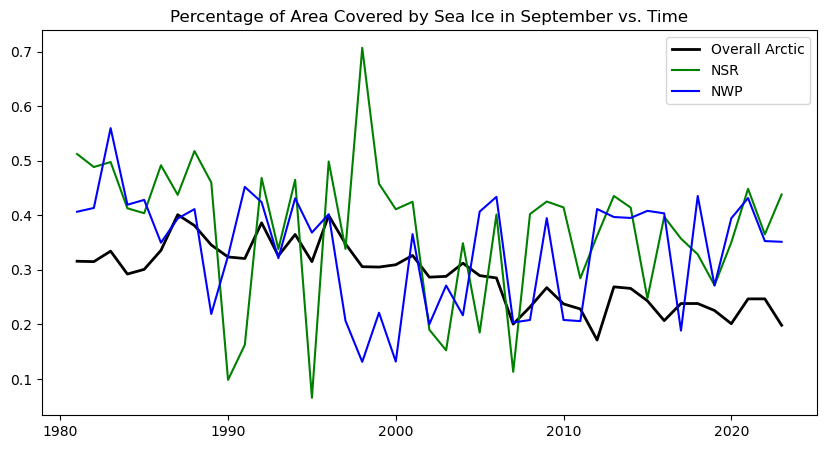

In [3]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(data['year'], data['arctic'], color='black', lw= 2, label='Overall Arctic')
ax.plot(data['year'], data['nsr'], color='green', label='NSR')
#ax.plot(data['year'], data['nsr_spot'], '--', color='green', label='NSR Trouble Spot')
ax.plot(data['year'], data['nwp'], color='blue', label='NWP')
#ax.plot(data['year'], data['nwp_spot'], '--', color='blue', label='NWP Trouble Spot')
ax.set_title('Percentage of Area Covered by Sea Ice in September vs. Time')
ax.legend()

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline

def fit_linear_model(x_values, y): 
    ### Fit a linear model to x and y values ###

    x_vals = x_values.reshape(-1, 1)
    y_vals = y.values

    model = LinearRegression(fit_intercept=True)

    lin_model = model.fit(x_vals, y_vals)

    print("Model slope:    ", lin_model.coef_[0]), print("Model intercept:", lin_model.intercept_)

    return lin_model

def fit_poly_model(x_values, y): 
    ### Fit a polynomial model to x and y values ###

    x_vals = x_values.reshape(-1, 1)
    y_vals = y.values

    model = make_pipeline(PolynomialFeatures(2),
                           LinearRegression())

    poly_model = model.fit(x_vals, y_vals)

    return poly_model

def model_vals(x_values, model):
    ### Calculate values along a model line with x_values and model inputs ###

    xfit = x_values
    yfit = model.predict(xfit[:, np.newaxis])

    return yfit


In [5]:
def lin_bootstrap(x_values, y_values, model_vals, n_bootstraps, x_predict):
    ### Calculate linear bootstraps given data (x_values and y_values), predicted model values. Input number of bootstraps and x-values for prediction ###

    n_bs = n_bootstraps
    bootstraps = []

    x_vals = x_values.reshape(-1, 1)
    residuals = y_values - model_vals

    for i in range(n_bs):
        
        bs_res = resample(residuals, replace=True, n_samples=len(residuals)) #Resample with replacement

        y_vals = model_vals + bs_res #Bootstrap "data"

        model = LinearRegression(fit_intercept=True) 
        lin_model = model.fit(x_vals, y_vals) #Fit linear regression to input x_vals and bootstrap data
    
        bs_vals = lin_model.predict(x_predict.reshape(-1, 1)) #Predict 

        bootstraps.append(bs_vals)

    bs_df = pd.DataFrame(bootstraps).T

    return bs_df

def poly_bootstrap(x_values, y_values, model_vals, n_bootstraps, x_predict):
    ### Calculate polynomial bootstraps given data (x_values and y_values), predicted model values. Input number of bootstraps and x-values for prediction ###

    n_bs = n_bootstraps
    bootstraps = []

    x_vals = x_values.reshape(-1, 1)
    residuals = y_values - model_vals

    for i in range(n_bs):
        
        bs_res = resample(residuals, replace=True, n_samples=len(residuals))

        y_vals = model_vals + bs_res 

        model = make_pipeline(PolynomialFeatures(2),
                           LinearRegression())

        poly_model = model.fit(x_vals, y_vals)
    
        bs_vals = poly_model.predict(x_predict.reshape(-1, 1))

        bootstraps.append(bs_vals)

    bs_df = pd.DataFrame(bootstraps).T

    return bs_df

Model slope:     -0.003583576104995934
Model intercept: 7.463429157431606
Model RMSE:   0.035180549157981814


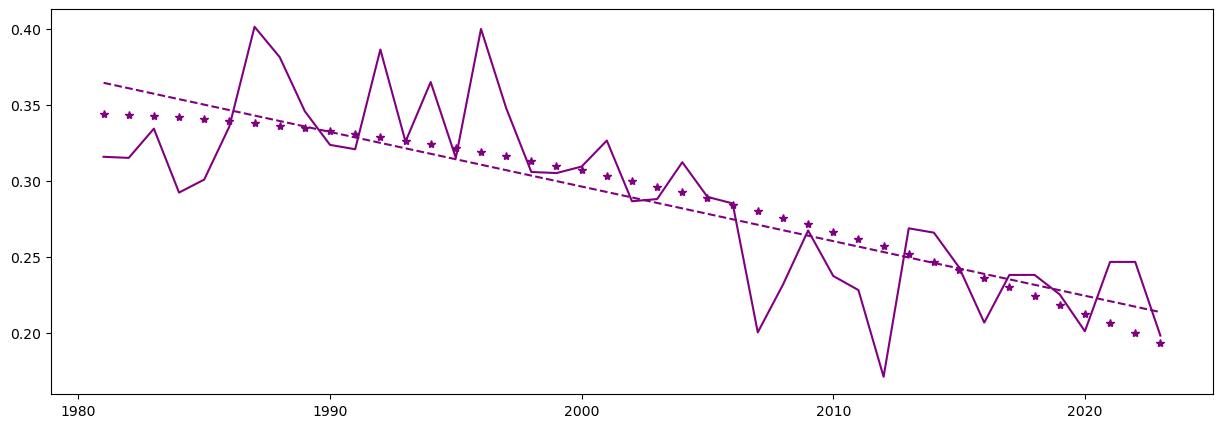

In [6]:
arctic_lin = fit_linear_model(data['year'].values, data['arctic'])
arctic_poly = fit_poly_model(data['year'].values, data['arctic'])
arctic_lin_vals = model_vals(data['year'].values, arctic_lin)
arctic_poly_vals = model_vals(data['year'].values, arctic_poly)
arctic_RMSE = mean_squared_error(data['arctic'], arctic_lin_vals, squared=False)
print("Model RMSE:  ", arctic_RMSE)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(data['year'], data['arctic'], color='purple')
ax.plot(data['year'], arctic_lin_vals, '--', color='purple')
ax.plot(data['year'], arctic_poly_vals, '*', color='purple')

Model slope:     -0.002019549476367745
Model intercept: 4.415078872077446
Model RMSE:   0.12651254898647013


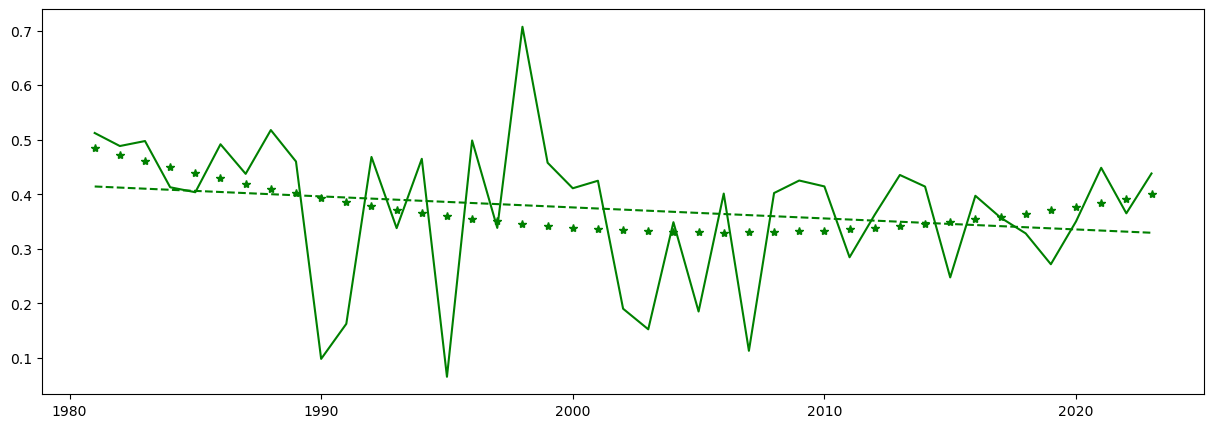

In [7]:
nsr_lin = fit_linear_model(data['year'].values, data['nsr'])
nsr_poly = fit_poly_model(data['year'].values, data['nsr'])
nsr_lin_vals = model_vals(data['year'].values, nsr_lin)
nsr_poly_vals = model_vals(data['year'].values, nsr_poly)
nsr_RMSE = mean_squared_error(data['nsr'], nsr_lin_vals, squared=False)
print("Model RMSE:  ", nsr_RMSE)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(data['year'], data['nsr'], color='green')
ax.plot(data['year'], nsr_lin_vals, '--', color='green')
ax.plot(data['year'], nsr_poly_vals, '*', color='green')

Model slope:     -0.007141350720902307
Model intercept: 15.073539738868535
Model RMSE:   0.25739031963742065


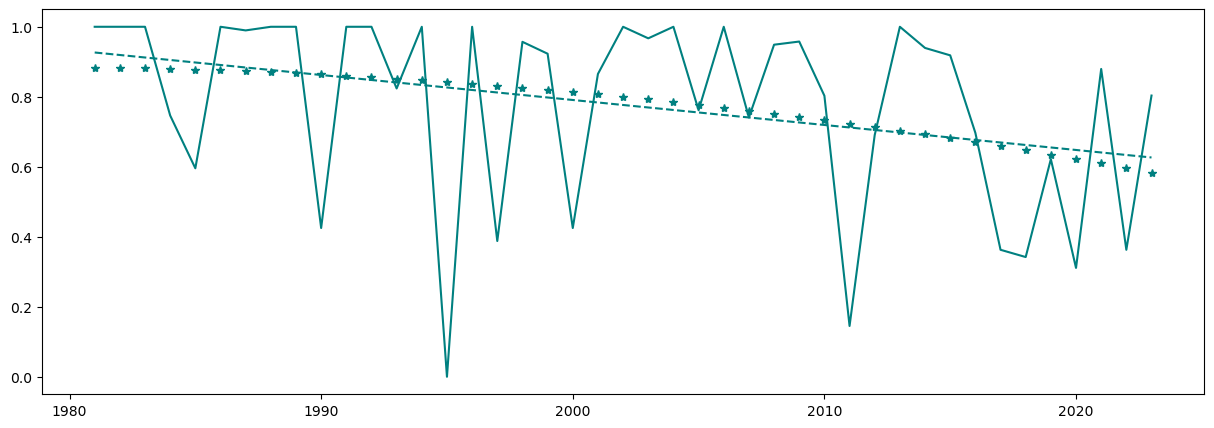

In [8]:
nsrts_lin = fit_linear_model(data['year'].values, data['nsr_spot'])
nsrts_lin_vals = model_vals(data['year'].values, nsrts_lin)
nsrts_poly = fit_poly_model(data['year'].values, data['nsr_spot'])
nsrts_poly_vals = model_vals(data['year'].values, nsrts_poly)
nsrts_RMSE = mean_squared_error(data['nsr_spot'], nsrts_lin_vals, squared=False)
print("Model RMSE:  ", nsrts_RMSE)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(data['year'], data['nsr_spot'], color='teal')
ax.plot(data['year'], nsrts_lin_vals, '--', color='teal')
ax.plot(data['year'], nsrts_poly_vals, '*', color='teal')

Model slope:     -0.0013829280660720019
Model intercept: 3.107554424113144
Model RMSE:   0.10004482336502689


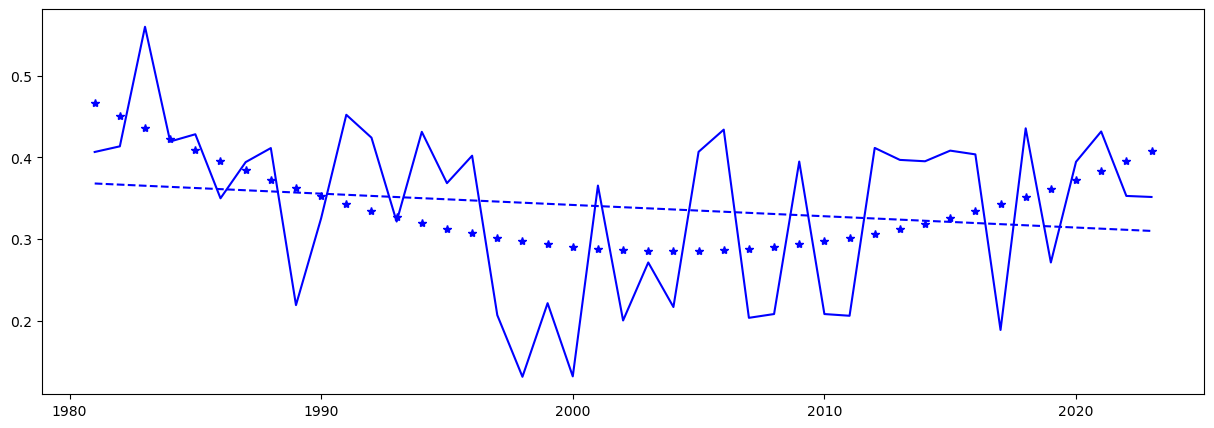

In [9]:
nwp_lin = fit_linear_model(data['year'].values, data['nwp'])
nwp_poly = fit_poly_model(data['year'].values, data['nwp'])
nwp_lin_vals = model_vals(data['year'].values, nwp_lin)
nwp_poly_vals = model_vals(data['year'].values, nwp_poly)
nwp_RMSE = mean_squared_error(data['nwp'], nwp_lin_vals, squared=False)
print("Model RMSE:  ", nwp_RMSE)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(data['year'], data['nwp'], color='blue')
ax.plot(data['year'], nwp_lin_vals, '--', color='blue')
ax.plot(data['year'], nwp_poly_vals, '*', color='blue')

Model slope:     -0.0008877986595157992
Model intercept: 2.741072138988648
Model RMSE:   0.06871990765739361


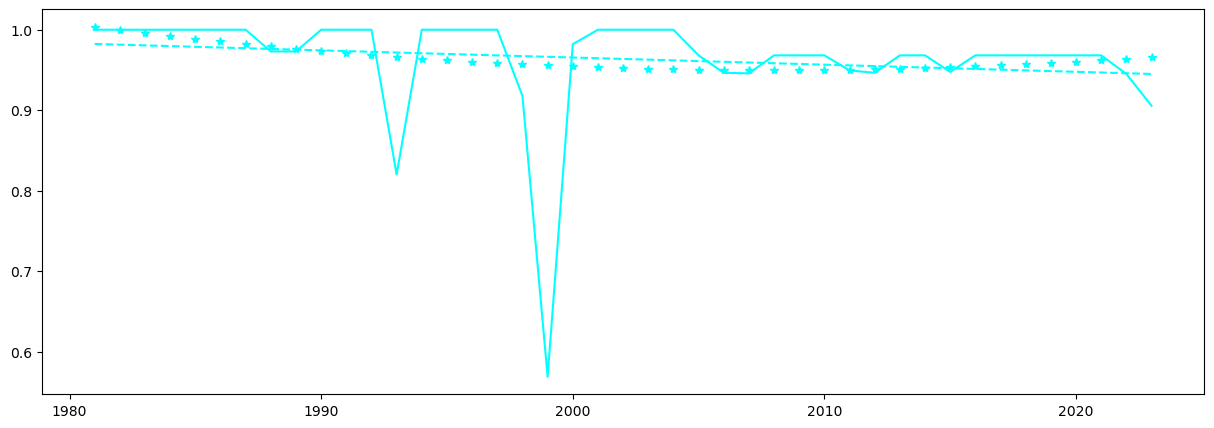

In [10]:
nwpts_lin = fit_linear_model(data['year'].values, data['nwp_spot'])
nwpts_lin_vals = model_vals(data['year'].values, nwpts_lin)
nwpts_poly = fit_poly_model(data['year'].values, data['nwp_spot'])
nwpts_poly_vals = model_vals(data['year'].values, nwpts_poly)
nwpts_RMSE = mean_squared_error(data['nwp_spot'], nwpts_lin_vals, squared=False)
print("Model RMSE:  ", nwpts_RMSE)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(data['year'], data['nwp_spot'], color='cyan')
ax.plot(data['year'], nwpts_lin_vals, '--', color='cyan')
ax.plot(data['year'], nwpts_poly_vals, '*', color='cyan')

Text(0.5, 1.0, 'Percent Area of Sea Ice Coverage in September')

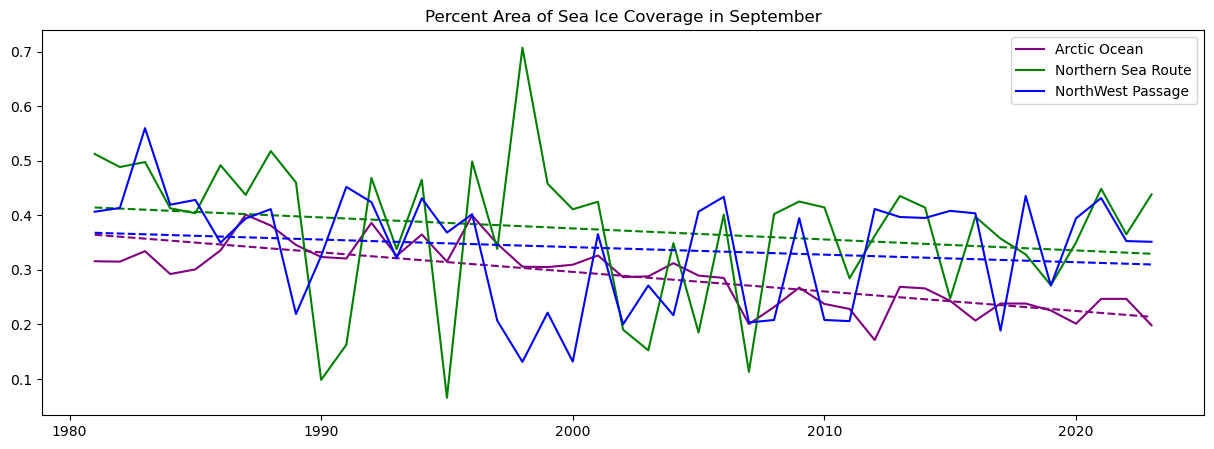

In [11]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(data['year'], data['arctic'], color='purple', label= 'Arctic Ocean')
ax.plot(data['year'], arctic_lin_vals, '--', color='purple')
ax.plot(data['year'], data['nsr'], color='green', label= 'Northern Sea Route')
ax.plot(data['year'], nsr_lin_vals, '--', color='green')
ax.plot(data['year'], data['nwp'], color='blue', label= 'NorthWest Passage')
ax.plot(data['year'], nwp_lin_vals, '--', color='blue')
ax.legend()
ax.set_title('Percent Area of Sea Ice Coverage in September')

In [12]:
# Create 1000 bootstraps for each area

arctic_bs = lin_bootstrap(data['year'].values, data['arctic'], arctic_lin_vals, 1000, data['year'].values)

nsr_bs = lin_bootstrap(data['year'].values, data['nsr'], nsr_lin_vals, 1000, data['year'].values)

nsrts_bs = lin_bootstrap(data['year'].values, data['nsr_spot'], nsrts_lin_vals, 1000, data['year'].values)

nwp_bs = lin_bootstrap(data['year'].values, data['nwp'], nwp_lin_vals, 1000, data['year'].values)

nwpts_bs = lin_bootstrap(data['year'].values, data['nwp_spot'], nwpts_lin_vals, 1000, data['year'].values)

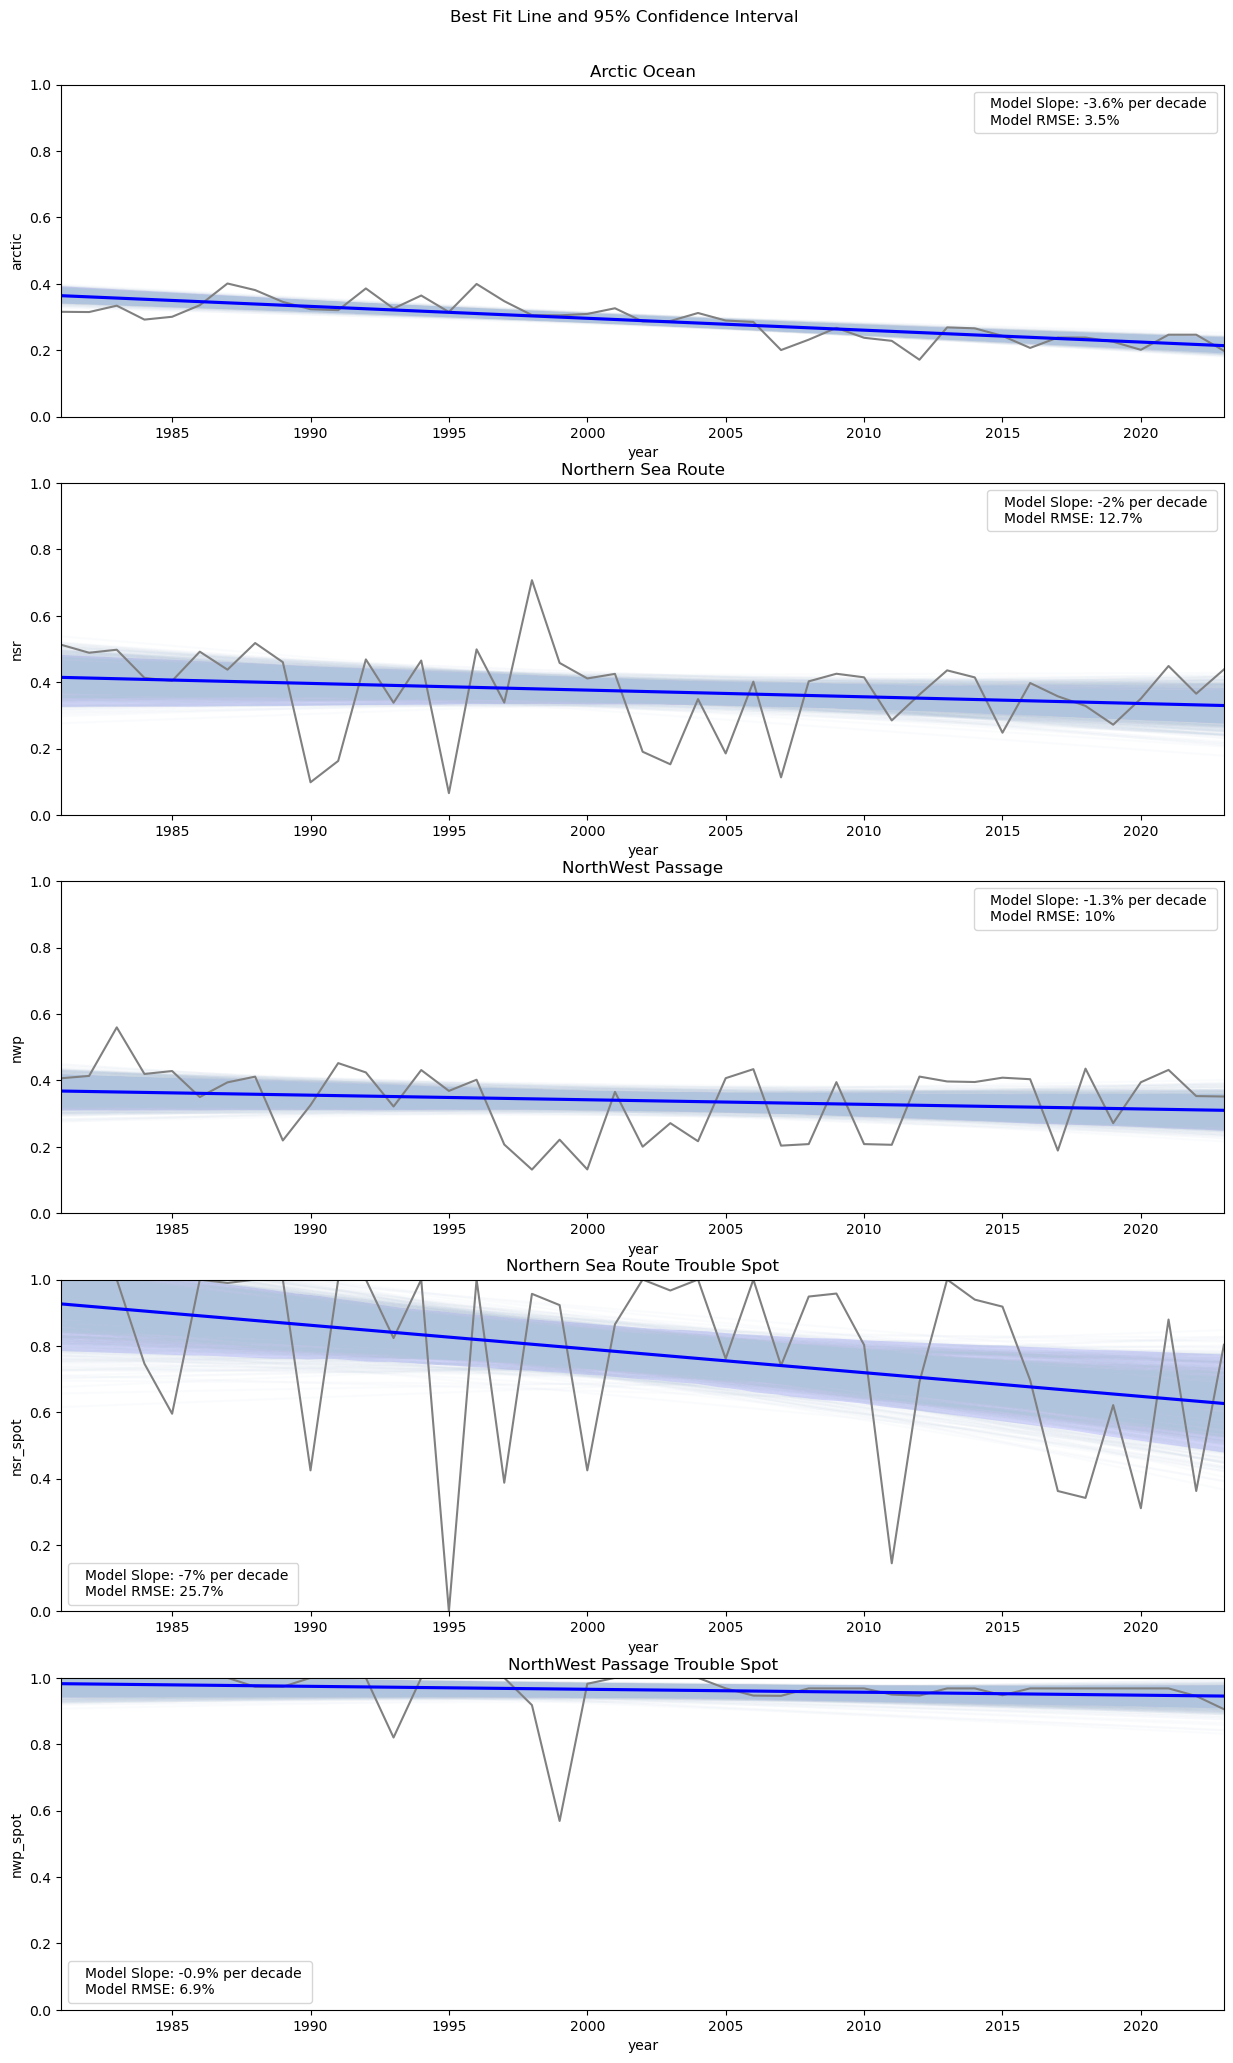

In [15]:
# Use seaborn to plot 95% CI for each linear regression model

import seaborn as sns

fig, ax = plt.subplots(5, 1, figsize=(15,25))
fig.suptitle('Best Fit Line and 95% Confidence Interval', y=0.91)

x = data['year']

ax[0].plot(x, arctic_bs, color='lightsteelblue', alpha=0.05)
ax[0].plot(x, data['arctic'], color='gray', label='Model Slope: -3.6% per decade \nModel RMSE: 3.5%')
sns.regplot(data=data, x=data['year'], y=data['arctic'], scatter=False, n_boot=1000, line_kws=dict(color='blue'), ax=ax[0])
ax[0].set_title('Arctic Ocean')
ax[0].set_xlim(1981,2023)
ax[0].set_ylim(0,1)
ax[0].legend(handlelength=0)

ax[1].plot(x, nsr_bs, color='lightsteelblue', alpha=0.05)
ax[1].plot(x, data['nsr'], color='gray', label='Model Slope: -2% per decade \nModel RMSE: 12.7%')
sns.regplot(data=data, x=data['year'], y=data['nsr'], scatter=False, n_boot=1000, line_kws=dict(color='blue'), ax=ax[1])
ax[1].set_title('Northern Sea Route')
ax[1].set_xlim(1981,2023)
ax[1].set_ylim(0,1)
ax[1].legend(handlelength=0)

ax[2].plot(x, nwp_bs, color='lightsteelblue', alpha=0.05)
ax[2].plot(x, data['nwp'], color='gray', label='Model Slope: -1.3% per decade \nModel RMSE: 10%')
sns.regplot(data=data, x=data['year'], y=data['nwp'], scatter=False, n_boot=1000, line_kws=dict(color='blue'), ax=ax[2])
ax[2].set_title('NorthWest Passage')
ax[2].set_xlim(1981,2023)
ax[2].set_ylim(0,1)
ax[2].legend(handlelength=0)

ax[3].plot(x, nsrts_bs, color='lightsteelblue', alpha=0.05)
ax[3].plot(x, data['nsr_spot'], color='gray', label='Model Slope: -7% per decade \nModel RMSE: 25.7%')
sns.regplot(data=data, x=data['year'], y=data['nsr_spot'], scatter=False, n_boot=1000, line_kws=dict(color='blue'), ax=ax[3])
ax[3].set_title('Northern Sea Route Trouble Spot')
ax[3].set_xlim(1981,2023)
ax[3].set_ylim(0,1)
ax[3].legend(handlelength=0)

ax[4].plot(x, nwpts_bs, color='lightsteelblue', alpha=0.05)
ax[4].plot(x, data['nwp_spot'], color='gray', label='Model Slope: -0.9% per decade \nModel RMSE: 6.9%')
sns.regplot(data=data, x=data['year'], y=data['nwp_spot'], scatter=False, n_boot=1000, line_kws=dict(color='blue'), ax=ax[4])
ax[4].set_title('NorthWest Passage Trouble Spot')
ax[4].set_xlim(1981,2023)
ax[4].set_ylim(0,1)
ax[4].legend(handlelength=0)

In [17]:
# Project the linear models and bootstraps to 2100

x_proj = np.linspace(1981, 2100, 119).reshape(-1, 1) # Project x out to 2100 

arctic_lin_proj = arctic_lin.predict(x_proj)
arctic_poly_proj = arctic_poly.predict(x_proj)
arctic_linbs_proj = lin_bootstrap(data['year'].values, data['arctic'].values, arctic_lin_vals, 1000, x_proj)
arctic_polybs_proj = poly_bootstrap(data['year'].values, data['arctic'].values, arctic_poly_vals, 1000, x_proj)

nsr_lin_proj = nsr_lin.predict(x_proj)
nsr_linbs_proj = lin_bootstrap(data['year'].values, data['nsr'].values, nsr_lin_vals, 1000, x_proj)

nsrts_lin_proj = nsrts_lin.predict(x_proj)
nsrts_linbs_proj = lin_bootstrap(data['year'].values, data['nsr_spot'].values, nsrts_lin_vals, 1000, x_proj)

nwp_lin_proj = nwp_lin.predict(x_proj)
nwp_linbs_proj = lin_bootstrap(data['year'].values, data['nwp'].values, nwp_lin_vals, 1000, x_proj)

nwpts_lin_proj = nwpts_lin.predict(x_proj)
nwpts_linbs_proj = lin_bootstrap(data['year'].values, data['nwp_spot'].values, nwpts_lin_vals, 1000, x_proj)


Text(0.5, 1.0, 'NorthWest Passage Trouble Spot')

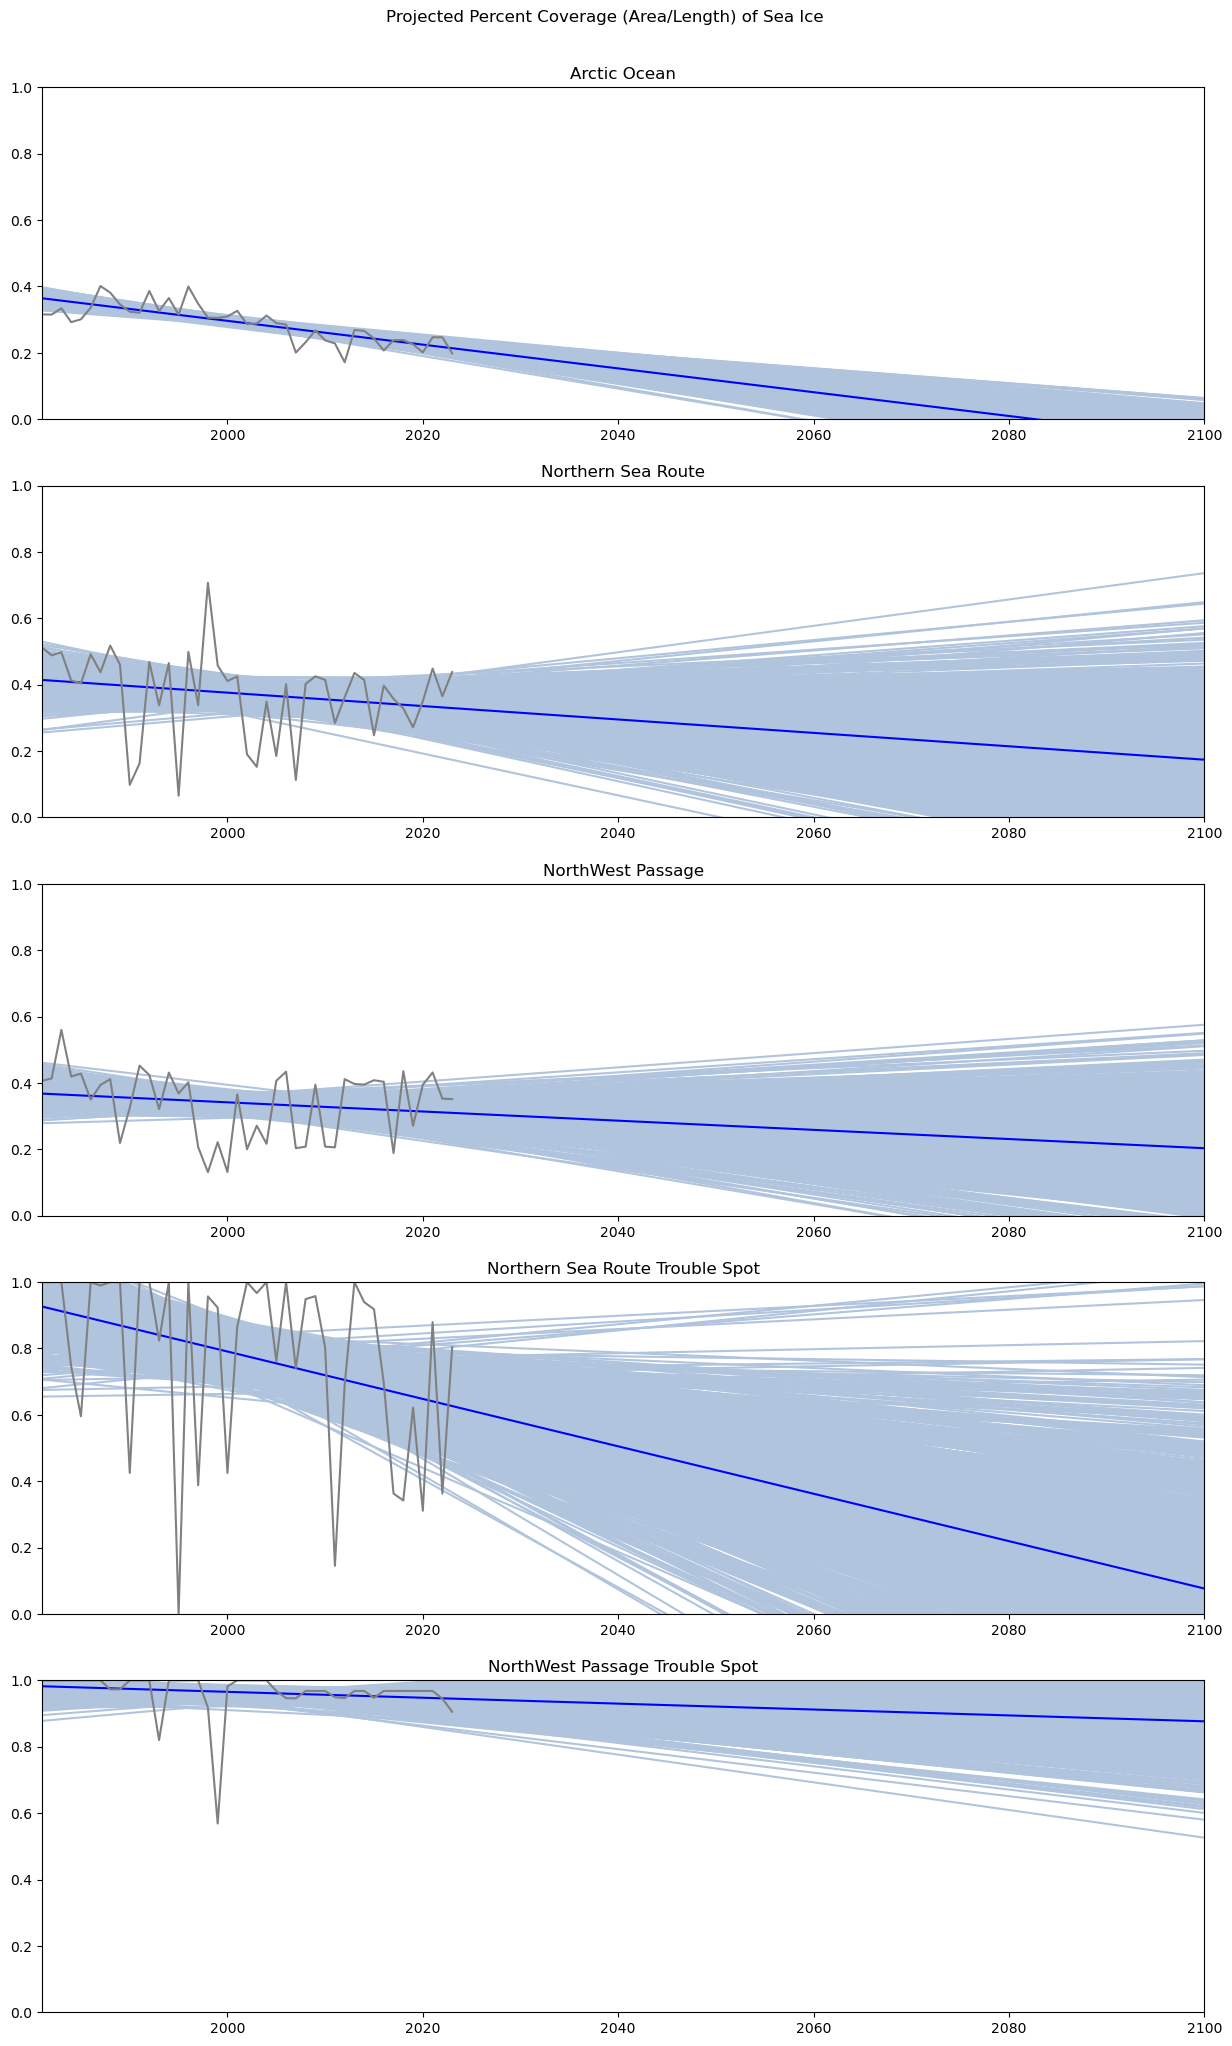

In [18]:
# Plot projected linear model and bootstraps to indicate when these trends predict "ice free" conditions

fig, ax = plt.subplots(5, 1, figsize=(15,25))
fig.suptitle('Projected Percent Coverage (Area/Length) of Sea Ice', y=0.911)

ax[0].plot(x_proj, arctic_linbs_proj, color='lightsteelblue')
ax[0].plot(x_proj, arctic_lin_proj, color='blue')
#ax[0].plot(x_proj, arctic_poly_proj, color='red')
ax[0].plot(data['year'], data['arctic'], color='gray')
ax[0].set_xlim(1981,2100)
ax[0].set_ylim(0,1)
ax[0].set_title('Arctic Ocean')

ax[1].plot(x_proj, nsr_linbs_proj, color='lightsteelblue')
ax[1].plot(x_proj, nsr_lin_proj, color='blue')
ax[1].plot(data['year'], data['nsr'], color='gray')
ax[1].set_xlim(1981,2100)
ax[1].set_ylim(0,1)
ax[1].set_title('Northern Sea Route')

ax[2].plot(x_proj, nwp_linbs_proj, color='lightsteelblue')
ax[2].plot(x_proj, nwp_lin_proj, color='blue')
ax[2].plot(data['year'], data['nwp'], color='gray')
ax[2].set_xlim(1981,2100)
ax[2].set_ylim(0,1)
ax[2].set_title('NorthWest Passage')

ax[3].plot(x_proj, nsrts_linbs_proj, color='lightsteelblue')
ax[3].plot(x_proj, nsrts_lin_proj, color='blue')
ax[3].plot(data['year'], data['nsr_spot'], color='gray')
ax[3].set_xlim(1981,2100)
ax[3].set_ylim(0,1)
ax[3].set_title('Northern Sea Route Trouble Spot')

ax[4].plot(x_proj, nwpts_linbs_proj, color='lightsteelblue')
ax[4].plot(x_proj, nwpts_lin_proj, color='blue')
ax[4].plot(data['year'], data['nwp_spot'], color='gray')
ax[4].set_xlim(1981,2100)
ax[4].set_ylim(0,1)
ax[4].set_title('NorthWest Passage Trouble Spot')